In [1]:
def marsh_elevation_rate(z_init, h_HW, n_events, c_flood, fd, rho_deposit, s_subsidence, slr, **kwargs):
        """
        Calculates the rate of change of marsh elevation with seasonal parameters per year.
        """
        seasonal_deposit = fd * sum(n_events[i] * c_flood * (h_HW[i] + slr - z_init) if (h_HW[i] + slr - z_init) > 0 else 0 for i in range(len(n_events)))
        dz_dt = (seasonal_deposit / rho_deposit) - (s_subsidence + slr) * 0.25  # Adjusted for season
        return dz_dt

def calculate_initial_dz_dt(initial_year_data, z_init, c_flood, fd, rho_deposit, s_subsidence, **kwargs):
        """
        Calculates the initial rate of change of marsh elevation for the first year.
        """
        h_HW = initial_year_data['high_water_height'].tolist()
        n_events = initial_year_data['num_tides'].tolist()
        slr = initial_year_data['slr'].unique()[0]

        initial_dz_dt = marsh_elevation_rate(z_init, h_HW, n_events, c_flood, fd, rho_deposit, s_subsidence, slr) - 0.75 * (s_subsidence + slr)
        return initial_dz_dt
    
    
def marsh_elevation_model(z_init, c_flood, c_flood_nourishment, fd, rho_deposit, s_subsidence, nourishment_frequency,
                                                        tides_per_year,  **kwargs):

        years_list = tides_per_year['year'].unique()
        start_year = years_list[0]
        z_values, dz_dt_values = [], []

    
        # Calculate the nourishment years
        nourishment_years = set(range(start_year, start_year + len(years_list) * nourishment_frequency, nourishment_frequency))

        for year in years_list:
                year_data = tides_per_year[tides_per_year['year'] == year]

                # Divide year data by season
                data_spring = year_data[year_data['season'] == 'spring']
                data_summer = year_data[year_data['season'] == 'summer']
                data_autumn = year_data[year_data['season'] == 'autumn']
                data_winter = year_data[year_data['season'] == 'winter']

                # Extract high water heights and event counts per season
                h_HW_spring, n_events_spring = data_spring['high_water_height'].tolist(), data_spring['num_tides'].tolist()
                h_HW_summer, n_events_summer = data_summer['high_water_height'].tolist(), data_summer['num_tides'].tolist()
                h_HW_autumn, n_events_autumn = data_autumn['high_water_height'].tolist(), data_autumn['num_tides'].tolist()
                h_HW_winter, n_events_winter = data_winter['high_water_height'].tolist(), data_winter['num_tides'].tolist()

                if year == start_year:
                        # Calculate initial rate of change for the first year
                        initial_dz_dt = calculate_initial_dz_dt(year_data, z_init, c_flood, fd, rho_deposit, s_subsidence)
                        z_init += initial_dz_dt
                        z_values.append(z_init)
                        dz_dt_values.append(initial_dz_dt)
                else:
                        slr = year_data['slr'].unique()[0]
                        # Apply nourishment concentration adjustments per season
                        if year in nourishment_years:
                                c_flood_spring = c_flood + c_flood_nourishment
                                c_flood_summer = c_flood + c_flood_nourishment
                                c_flood_autumn = (c_flood + c_flood_nourishment* 0.6)
                                c_flood_winter = c_flood
                        else:
                                c_flood_spring = c_flood
                                c_flood_summer = c_flood
                                c_flood_autumn = c_flood
                                c_flood_winter = c_flood

                        # Seasonal sedimentation fraction adjustments
                        fd_spring, fd_summer, fd_autumn, fd_winter = fd * 0.6, fd, fd * 0.5, fd * 0.2

                        # Calculate dz/dt for each season and aggregate
                        dz_dt_spring = marsh_elevation_rate(z_init, h_HW_spring, n_events_spring, c_flood_spring, fd_spring, rho_deposit, s_subsidence, slr)
                        dz_dt_summer = marsh_elevation_rate(z_init, h_HW_summer, n_events_summer, c_flood_summer, fd_summer, rho_deposit, s_subsidence, slr)
                        dz_dt_autumn = marsh_elevation_rate(z_init, h_HW_autumn, n_events_autumn, c_flood_autumn, fd_autumn, rho_deposit, s_subsidence, slr)
                        dz_dt_winter = marsh_elevation_rate(z_init, h_HW_winter, n_events_winter, c_flood_winter, fd_winter, rho_deposit, s_subsidence, slr)

                        # Aggregate seasonal dz/dt and update elevation
                        dz_dt = dz_dt_spring + dz_dt_summer + dz_dt_autumn + dz_dt_winter
                        z_init += dz_dt

                        z_values.append(z_init)
                        dz_dt_values.append(dz_dt)

        return z_values, years_list, dz_dt_values


In [2]:
import os
import pandas as pd
os.chdir('C:/Users/cschott/Desktop/FutureUrbanCoastlines/GITHUB/ExMAM/DAPP_session_x_marsh/marsh_model')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter # for smoothing the time-series
#from matplotlib.lines import Line2D
import seaborn as sns


## Input data

In [4]:
tides_per_year = pd.read_csv('model_input_X_L/tides_rcp85_S15.tsv', sep='\t')
slr_rcp_85 = pd.read_csv('model_input_X_L/slr85.csv', sep=',')
slr_rcp_26 = pd.read_csv('model_input_X_L/slr26.csv', sep=',')

In [5]:
z_init = 0.7               # Initial elevation in pioneer zone
c_flood = 0.05             # Low background sediment concentration
rho_deposit = 400          # Low dry buld density due to low mineral content of suspended sediments 
s_subsidence = 0.003       # Autocompaction rate
c_flood_nourishment = 0.0  # No nourishment strategy
nourishment_frequency = 1  # No nourishment every year
fd = 0.4                   # Sediment trapping ability related to conservation strategy

In [6]:
slr_series_dict = {
    'result_low_26' : slr_rcp_26[['year', 'delta_min_slr',  'min_slr']].rename(columns= {'delta_min_slr':  'slr', 'min_slr':  'msl'}),
    'result_mean_26': slr_rcp_26[['year', 'delta_mean_slr', 'mean_slr']].rename(columns={'delta_mean_slr': 'slr', 'mean_slr': 'msl'}),
    'result_high_26': slr_rcp_26[['year', 'delta_max_slr',  'max_slr']].rename(columns= {'delta_max_slr':  'slr', 'max_slr':  'msl'}),
    'result_low_85' : slr_rcp_85[['year', 'delta_min_slr',  'min_slr']].rename(columns= {'delta_min_slr':  'slr', 'min_slr':  'msl'}),
    'result_mean_85': slr_rcp_85[['year', 'delta_mean_slr', 'mean_slr']].rename(columns={'delta_mean_slr': 'slr', 'mean_slr': 'msl'}),
    'result_high_85': slr_rcp_85[['year', 'delta_max_slr',  'max_slr']].rename(columns= {'delta_max_slr':  'slr', 'max_slr':  'msl'}),
}

For each concentration pathway RCP2.6 or RCP8.5, the projected rise in sea level is stored for the 
the upper, lower and central estimate in the 5–95 \% confidence interval of CMIP5 projections. 

Regional sea level rise inputs follow AR5 projections Church et al., 2013a provided by the Integrated Climate Data Center (ICDC) at the University of Hamburg’s Center for Earth System Research and Sustainability (CEN) and are anchored to the   1986–2005 baseline. Uncertainties were derived from the CMIP5 ensemble. By treating model spread as a normal distribution, the 5–95 \% confidence interval of CMIP5 projections is assumed as a likely range \citep{church2013SUP}.



In [7]:
scenarios = [
    ('result_low_26',  slr_rcp_26, 'delta_min_slr',  'min_slr'),
    ('result_mean_26', slr_rcp_26, 'delta_mean_slr', 'mean_slr'),
    ('result_high_26', slr_rcp_26, 'delta_max_slr',  'max_slr'),
    ('result_low_85',  slr_rcp_85, 'delta_min_slr',  'min_slr'),
    ('result_mean_85', slr_rcp_85, 'delta_mean_slr', 'mean_slr'),
    ('result_high_85', slr_rcp_85, 'delta_max_slr',  'max_slr'),
]

slr_series_dict = {
    name: df[['year', delta_col, msl_col]].rename(
        columns={delta_col: 'slr', msl_col: 'msl'}
    )
    for name, df, delta_col, msl_col in scenarios
}

In [8]:
results = {}

for result_name, slr_series in slr_series_dict.items():
    merged_data = tides_per_year.merge(slr_series, on='year', how='left')
    #msl_series = merged_data['msl'].values
    
    msl = slr_series['msl']
    z_vals, years, dz_vals = marsh_elevation_model(
        z_init=z_init,
        c_flood=c_flood,
        c_flood_nourishment=c_flood_nourishment,
        fd=fd,
        rho_deposit=rho_deposit,
        s_subsidence=s_subsidence,
        nourishment_frequency=nourishment_frequency,
        tides_per_year=merged_data
    )
     

    results[result_name] = pd.DataFrame({
        'year': years,
        'elevation': z_vals,
        'dz_dt': dz_vals,
        'msl': msl,
    })

In [9]:
for result_name, df in results.items():
    df.to_csv(f'model_output_M/Accretion_time_series/{result_name}.txt', sep='\t', index=False)

The time series output from each scenario is now stored in the ``results`` dictionary, where the keys (``result_name``) identify the scenario and the values contain the corresponding time series as DataFrames. To avoid repeatedly accessing them with ``results[result_name``] in the plot command, we unpack the dictionary into individual variables in the global namespace. Each key becomes a standalone variable name, directly assigned to its associated DataFrame for more convenient access in later analysis or plotting.

In [10]:
for name, df in results.items():
       globals()[name] = df

The final step in data pre-processing before plotting involves smoothing the accretion time series. This step serves purely aesthetic purposes, helping to create cleaner and more visually appealing plots without altering the underlying trends.Last step in data pre-processing for plotting is smoothing the accretion time series, which has purely aesthetic.

In [11]:
# Apply Savitzky-Golay filter
window_size = 10  # Window size must be odd
poly_order = 1
smoothed_low_26 = savgol_filter(result_low_26['dz_dt'], window_size, poly_order)
smoothed_mean_26 = savgol_filter(result_mean_26['dz_dt'], window_size, poly_order)
smoothed_high_26 = savgol_filter(result_high_26['dz_dt'], window_size, poly_order)

smoothed_low_85 = savgol_filter(result_low_85['dz_dt'], window_size, poly_order)
smoothed_mean_85 = savgol_filter(result_mean_85['dz_dt'], window_size, poly_order)
smoothed_high_85 = savgol_filter(result_high_85['dz_dt'], window_size, poly_order)

#### Plot accretion rate vs year


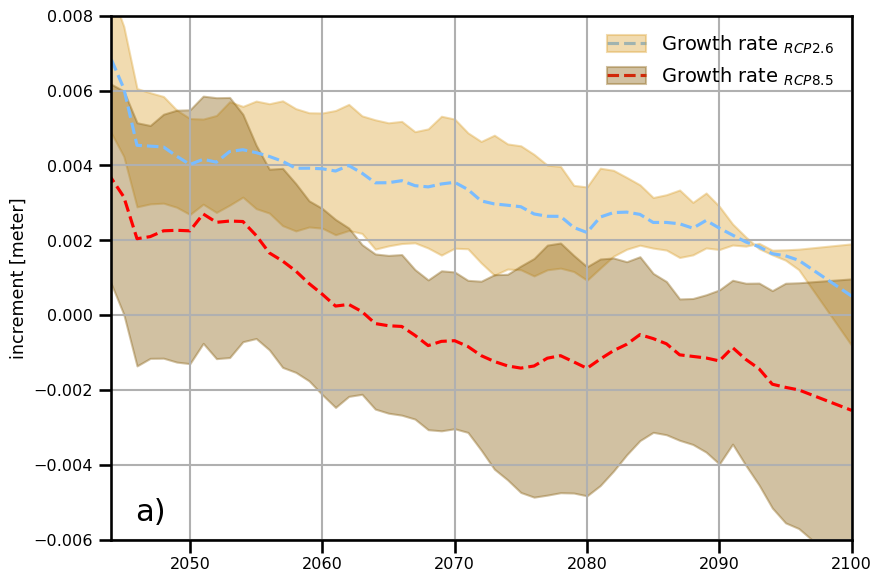

In [19]:
fig, ax1 = plt.subplots(figsize=(9,6))  # adjust size as needed

### RCP 2.6
### marsh-growth
p1_26 = ax1.plot(result_low_26['year'], smoothed_mean_26, linestyle='--', color='#79BCFF')
ax1.fill_between(result_low_26['year'], smoothed_low_26, smoothed_high_26, color='#DDA63A', alpha=0.4)

### RCP 8.5
### marsh-growth
p1_85 = ax1.plot(result_mean_85['year'], smoothed_mean_85, linestyle='--', color='#FF0000')
ax1.fill_between(result_mean_85['year'], smoothed_low_85, smoothed_high_85, color='#8C6518', alpha=0.4)

ax1.set_xlim(2044, 2100)
ax1.set_ylim(-0.006, 0.008)
###############    Customize legend    ####################
#Create an invisible fill to use in the legend.
p2_26 = ax1.fill(np.NaN, np.NaN,  color='#DDA63A', alpha=0.4)
p2_85= ax1.fill(np.NaN, np.NaN,  color='#8C6518', alpha=0.4)


handles = [(p1_26[0], p2_26[0]), (p1_85[0], p2_85[0])]
labels = [r'Growth rate $_{RCP 2.6}$', r'Growth rate $_{RCP 8.5}$']


ax1.legend(handles, labels, handleheight=1, loc='best',frameon=False, prop={'size': 14})

ax1.set_ylabel('increment [meter]')
ax1.grid(True)

ax1.annotate(
    r'a)',
    xy=(2047, -0.0050),
    xytext=(2047, -0.0055),  # Position of text slightly above and to the right
    ha='center',fontsize=22
)


# Set the context to increase overall font size
sns.set_context("talk", font_scale=0.7)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig('TS_Rate_Pio_S15_conservation.png')
plt.show()

#### Plot elevation above sea level versus year

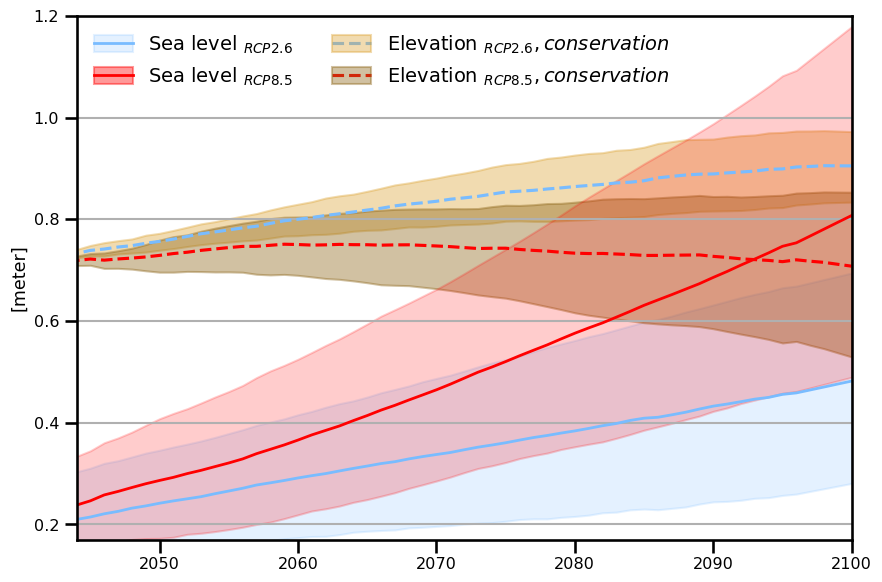

In [18]:

fig, ax2 = plt.subplots(figsize=(9,6)) 

### RCP 2.6
### marsh-growth
p1_26_E = ax2.plot(result_mean_26['year'], result_mean_26['elevation'], label=r'$z_{marsh}$',  linestyle='--', color='#79BCFF')
ax2.fill_between(result_mean_26['year'], result_low_26['elevation'], result_high_26['elevation'], color='#DDA63A', alpha=0.4)

### sea-level-rise
p1_26_slr = ax2.plot(result_mean_26['year'], result_mean_26['msl'], linestyle='-', color='#79BCFF',linewidth=2)
ax2.fill_between(result_low_26['year'], result_low_26['msl'], result_high_26['msl'], color='#79BCFF', alpha=0.2)



#### RCP 8.5
### marsh-growth
p1_85_E = ax2.plot(result_mean_85['year'], result_mean_85['elevation'], label=r'$z_{marsh}$',linestyle='--', color='#FF0000')
ax2.fill_between(result_low_85['year'], result_low_85['elevation'], result_high_85['elevation'], color='#8C6518', alpha=0.4)

### sea-level-rise
p1_85_slr = ax2.plot(result_mean_85['year'], result_mean_85['msl'],  linestyle='-', color='#FF0000',linewidth=2)
ax2.fill_between(result_low_85['year'], result_low_85['msl'], result_high_85['msl'], color='#FF0000', alpha=0.2)


ax2.set_xlim(2044, 2100)
ax2.set_ylim(0.17, 1.2)

###############    Customize legend    ####################
#Creates an invisible fill to use in the legend.
### Elevation
p2_26_E = ax1.fill(np.NaN, np.NaN,  color='#DDA63A', alpha=0.4)
p2_85_E= ax1.fill(np.NaN, np.NaN,  color='#8C6518', alpha=0.4)

### SLR
p2_26_slr = ax2.fill(np.NaN, np.NaN,  color='#79BCFF', alpha=0.2)
p2_85_slr = ax2.fill(np.NaN, np.NaN,  color='#FF0000', alpha=0.4)



handles = [(p1_26_slr[0], p2_26_slr[0]), (p1_85_slr[0], p2_85_slr[0]),  (p1_26_E[0], p2_26_E[0]), (p1_85_E[0], p2_85_E[0])]
labels = [r'Sea level $_{RCP 2.6}$', r'Sea level $_{RCP 8.5}$',  r'Elevation $_{RCP 2.6}, conservation$',
          r'Elevation $_{RCP 8.5}, conservation$' ]
ax2.legend(handles, labels, ncol=2, handleheight=1, prop={'size': 14},loc='upper left',frameon=False )

ax2.set_ylabel('[meter]')
ax2.grid(True)

ax2.grid(axis='x', visible=False)

# Set the context to increase overall font size
sns.set_context("talk", font_scale=0.7)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig('TS_Elevation_Pio_S15_conservation.png')
plt.show()